In [15]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

use_gpu = torch.cuda.is_available()

In [16]:
#Utility functions for cleaning the data

def cleanLabel(x):
    
    labelCount = 0    
    if x.Pleural_Effusion == 1:
        labelCount += 1
    if x.Edema == 1:
        labelCount += 1
    if x.Cardiomegaly ==1:
        labelCount += 1
    if x.Pneumonia == 1:
        labelCount += 1
    return labelCount
    
    

def getLabel(x):
    
    if x.Pleural_Effusion ==1:
        return "Pleural_Effusion"
    elif x.Edema == 1:
        return "Edema"
    elif x.Cardiomegaly==1:
        return "Cardiomegaly"
    elif x.Pneumonia == 1:
        return "Pneumonia"
    else:
        return "None"

In [17]:
baseFolder = "./"

#Dataframe columns
cols = ['Path',
 'Sex',
 'Age',
 'View',
 'AP/PA',
 'No_Finding',
 'Enlarged_Cardiomediastinum',
 'Cardiomegaly',
 'Lung_Opacity',
 'Lung_Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Effusion',
 'Pleural_Other',
 'Fracture',
 'Support_Devices']

pathFileTrain = baseFolder + 'train.csv'
pathFileValid = baseFolder + 'valid.csv'

In [18]:
#For 4 classes
labelMap = {"Pleural_Effusion":0, "Edema":1,"Cardiomegaly":2,"Pneumonia":3}

def getLabelDf(x):
    x = x[36:]          #To account for the extra "././" added before the Path variable
    x = df.loc[df.Path == x] 
    return labelMap[x.label.values[0]]

In [23]:
class LungDataset(Dataset):
    def __init__(self, baseFolder, file, transform=None):
        image_files = []
        labels = []

        with open(file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_file= line[0]
                
                #Create a 14 class label with 0s and 1s for the corresponding pathologies
                label = line[5:]
                
                #Handling uncertainity
                # TODO: Also try 0s for Us
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            label[i] = 1
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0       
                #TODO: Change when running locally!    
                image_files.append(baseFolder + image_file)
                labels.append(label)

        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        location = self.image_files[index]
        image = Image.open(location).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_files)

In [24]:
img_size = (256, 256)
#Transformations
transformList = []
transformList.append(transforms.Resize(img_size))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))      
transformSequence=transforms.Compose(transformList)

In [25]:

trainDataset = LungDataset('../',pathFileTrain, transformSequence)  

validationDataset = LungDataset('../',pathFileValid, transformSequence)  

In [26]:
e = next(iter(trainDataset))
e[0].size()

torch.Size([3, 256, 256])

In [27]:
train_data_loader = DataLoader(trainDataset, batch_size= 16, shuffle = True)
validation_loader = DataLoader(validationDataset, batch_size= 16, shuffle = True)

In [28]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [29]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        #print("X shape!!!")
        #print(x.shape)
        #print(model)
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [30]:
iterationAccuracy = []
iterationLoss = []

def train(net, optimizer, criterion, train_loader, test_loader, epochs, size, model_name, plot):
    model = net
    total_step = len(train_loader)
    overall_step = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            
            
            #print("The shape")
            #print(images.shape)
            
            #print("new image")
            
            images = images
            images = images.view(images.size(0), -1)
            #print(images.shape)
            labels = labels
            #Forward Pass
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            _, prediction = torch.max(outputs,1)
            #accuracy = (labels == prediction.squeeze()).float().mean()
            
            overall_step+=1
            if(i % 10 == 0):
                
                if(epoch == 0):
                    iterationLoss.append((i, loss))
                    print (i)
                if(epoch == 1):
                    iterationLoss.append((i + 2640, loss))
                    print(i)
                if(epoch == 2):
                    iterationLoss.append((i + (2640 * 2), loss))
                    print(i)

In [31]:
device = torch.device('cuda:0')

input_size = 256 * 256 * 3
num_classes = 4
learning_rate = 0.001

num_classes = 4
learning_rate = 0.0001
model = LogisticRegression(input_size, num_classes)
criterion = torch.nn.BCELoss(size_average = True)
optimizer = torch.optim.Adam (model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
epochs = 3


In [32]:
train(model, optimizer, criterion, train_data_loader, validation_loader, epochs, input_size , 'densenet-14c', True)

ValueError: Target and input must have the same number of elements. target nelement (224) != input nelement (64)

In [32]:
#iterationLoss[-1]
batch = []
loss = []
for i in range(len(iterationLoss)):
    batch.append(iterationLoss[i][0])
    loss.append(iterationLoss[i][1])

In [33]:
batch[-1]

11080

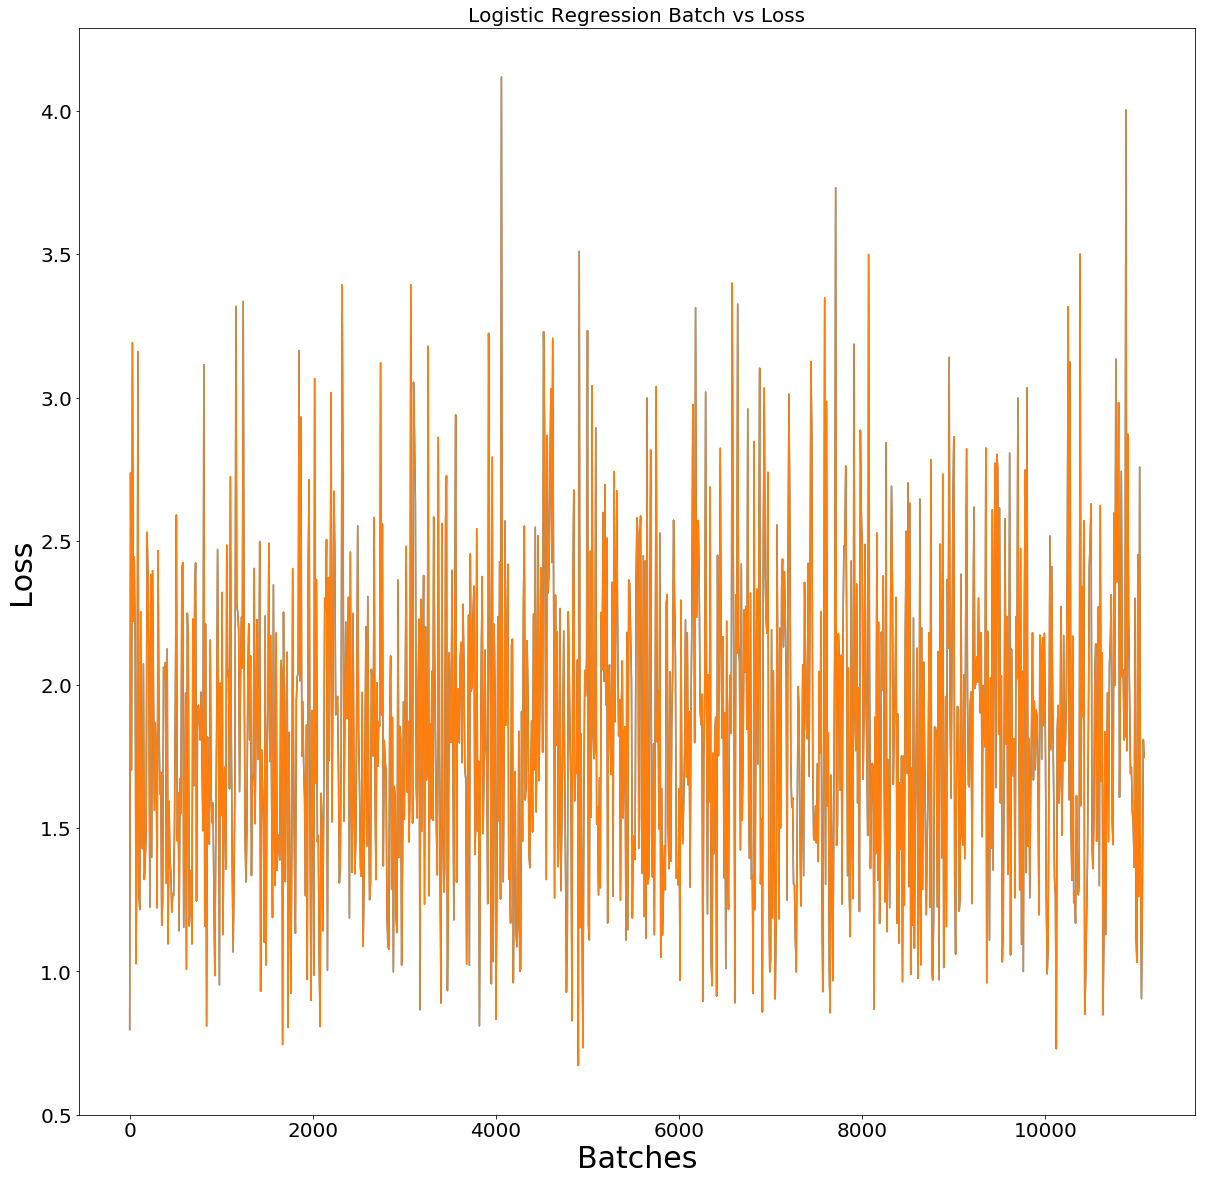

In [39]:
plt.plot(batch, loss)
plt.xlabel('Batches', fontsize = 30)
plt.ylabel('Loss', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Logistic Regression Batch vs Loss", fontsize = 20)
plt.show()

In [40]:

def computeAUROC (data, predicted, classCount):

    auroc = []

    data_np = data.cpu().numpy()
    data_np_pred = predicted.cpu().numpy()

    for i in range(classCount):
        try:
            auroc.append(roc_auc_score(data_np[:, i], data_np_pred[:, i]))
        except ValueError:
            pass
    return auroc



def test(model, test_loader, class_count, class_names):   

   
    out = torch.FloatTensor()
    out_pred = torch.FloatTensor()
    model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            image = image
            image = image.view(image.size(0), -1)
            
            target = label
            out = torch.cat((out, target), 0)

            #print(model)
            outV = model(image)
            out_pred = torch.cat((out_pred, outV), 0)
        
    aurocIndividual = computeAUROC(out, out_pred, class_count)
    aurocMean = np.array(aurocIndividual).mean()

    print ('AUROC mean ', aurocMean)

    for i in range (0, len(aurocIndividual)):
        print (class_names[i], ' ', aurocIndividual[i])

    return out, out_pred

In [41]:

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
out, out_pred = test(model, validation_loader, 4, class_names)

AUROC mean  0.5774954259
No Finding   0.703410311493
Enlarged Cardiomediastinum   0.514055045872
Cardiomegaly   0.463855421687
Lung Opacity   0.635802469136
Lung Lesion   0.502145922747
Edema   0.551557907113
Consolidation   0.613146389266
Pneumonia   0.719579646018
Atelectasis   0.539448051948
Pneumothorax   0.47842920354
Pleural Effusion   0.698096344624
Pleural Other   0.502145922747
Fracture   0.585767900508


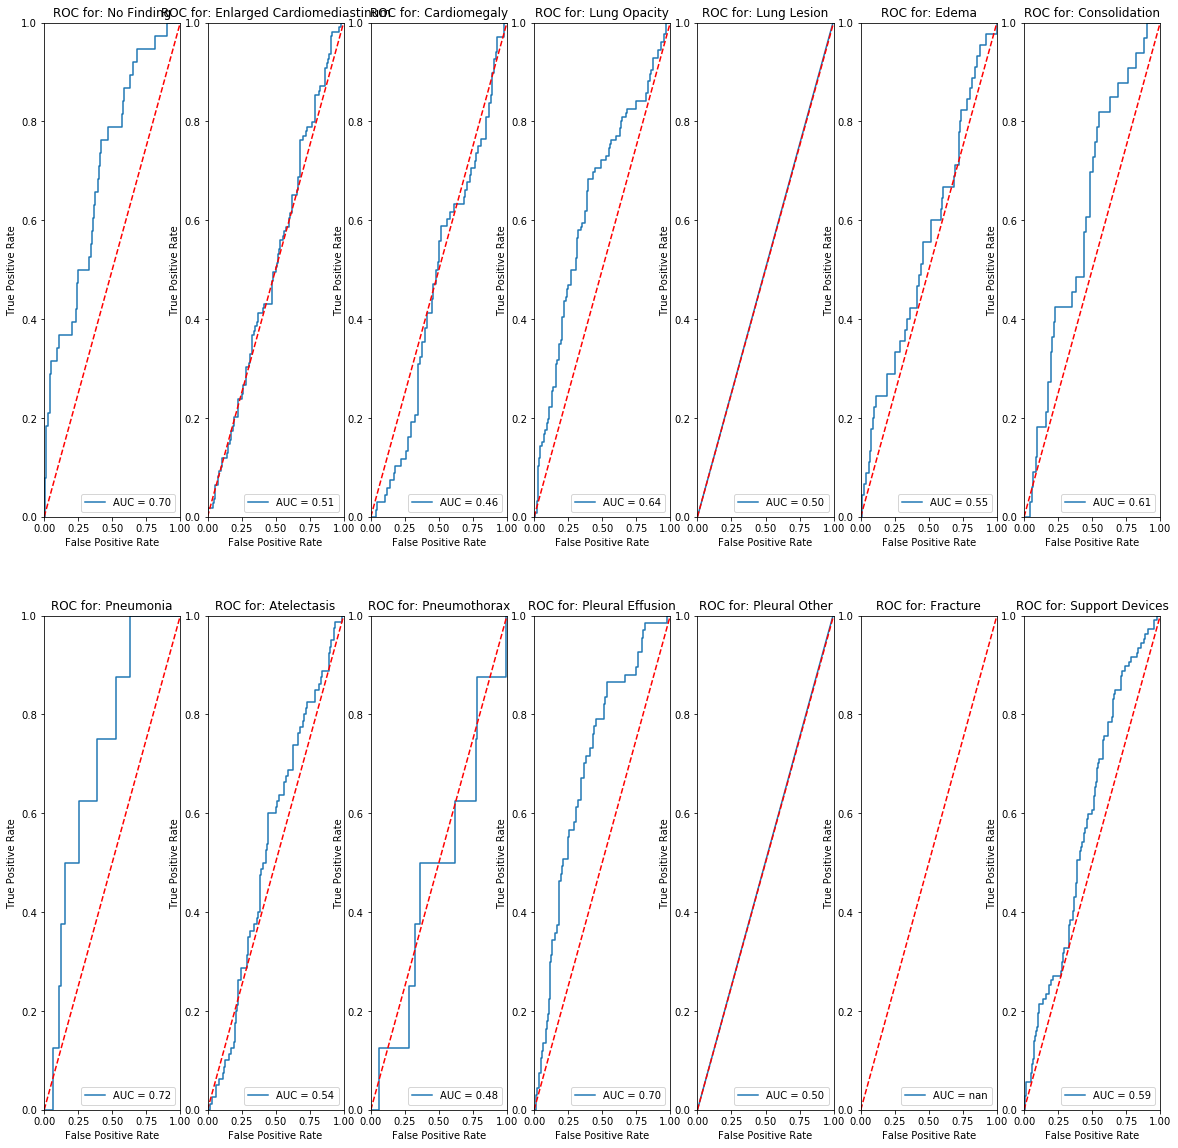

In [42]:
for i in range(4):
    fpr, tpr, threshold = metrics.roc_curve(out.cpu()[:,i], out_pred.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


plt.show()